<a href="https://colab.research.google.com/github/whbpt/mfDCA/blob/master/DCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# ------------------------------------------------------------
# Copyright for colab implementation: 
# "THE BEERWARE LICENSE" (Revision 42):
# <haobowang@fas.harvard.edu> reimplement this code.
# As long as you retain this notice, you can do whatever you want
# with this stuff. If we meet someday, and you think this stuff
# is worth it, you can buy us a beer in return.
# --Haobo Wang
# ------------------------------------------------------------
#
# Any publication resulting from applications of DCA should cite:
#
#     F Morcos, A Pagnani, B Lunt, A Bertolino, DS Marks, C Sander, 
#     R Zecchina, JN Onuchic, T Hwa, M Weigt (2011), Direct-coupling
#     analysis of residue co-evolution captures native contacts across 
#     many protein families, Proc. Natl. Acad. Sci. 108:E1293-1301.l

## libraries

In [0]:
# IMPORTANT, only tested using PYTHON 3!
import numpy as np
import matplotlib.pylab as plt
from scipy import stats
import pandas as pd

## Params

In [0]:
################
# note: if you are modifying the alphabet
# make sure last character is "-" (gap)
################
alphabet = "ARNDCQEGHILKMFPSTWYV-"
#alphabet ='-ACDEFGHIKLMNPQRSTVWY'
states = len(alphabet)
a2n = {}
for a,n in zip(alphabet,range(states)):
  a2n[a] = n
################

def aa2num(aa):
  '''convert aa into num'''
  if aa in a2n: return a2n[aa]
  else: return a2n['-']
       

## Functions

In [0]:
# from fasta
def parse_fasta(filename,limit=-1):
  '''function to parse fasta'''
  header = []
  sequence = []
  lines = open(filename, "r")
  for line in lines:
    line = line.rstrip()
    if line[0] == ">":
      if len(header) == limit:
        break
      header.append(line[1:])
      sequence.append([])
    else:
      sequence[-1].append(line)
  lines.close()
  sequence = [''.join(seq) for seq in sequence]
  return np.array(header), np.array(sequence)
  
def mk_msa(seqs):
  '''converts list of sequences to numpy array'''
  msa = []
  for seq in seqs:
    msa.append([aa2num(aa) for aa in seq])
  return np.array(msa)

def filt_gaps(msa,gap_cutoff=0.5):
  '''filters alignment to remove gappy positions'''
  tmp = np.zeros_like(msa)
  tmp[np.where(msa == 20)] = 1
  non_gaps = np.where(np.sum(tmp.T,-1).T/msa.shape[0] < gap_cutoff)[0]
  return msa[:,non_gaps],non_gaps

def get_eff(msa,eff_cutoff=0.8):
  '''compute effective weight for each sequence'''
  ncol = msa.shape[1]
  # pairwise identity
  msa_sm = (msa[:,None,:]==msa).sum(2)/ncol

  # weight for each sequence
  msa_w = np.zeros_like(msa_sm)
  msa_w[np.where(msa_sm >= eff_cutoff)] = 1
  msa_w = 1/np.sum(msa_w,-1)
  
  return msa_w

###################
def normalize(x):
  x = stats.boxcox(x - np.amin(x) + 1.0)[0]
  x_mean = np.mean(x)
  x_std = np.std(x)
  return((x-x_mean)/x_std)

In [5]:
# download example fasta MSA
!wget https://gremlin2.bakerlab.org/db/PDB/fasta/2khk_A.fas

--2018-12-29 00:30:55--  https://gremlin2.bakerlab.org/db/PDB/fasta/2khk_A.fas
Resolving gremlin2.bakerlab.org (gremlin2.bakerlab.org)... 128.95.160.155
Connecting to gremlin2.bakerlab.org (gremlin2.bakerlab.org)|128.95.160.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 158585 (155K)
Saving to: ‘2khk_A.fas’

2khk_A.fas          100%[===================>] 154.87K  --.-KB/s    in 0.02s   

2018-12-29 00:31:00 (6.25 MB/s) - ‘2khk_A.fas’ saved [158585/158585]



In [0]:
# parse fasta
names, seqs = parse_fasta("2khk_A.fas")

# convert seqs to array
msa = mk_msa(seqs)

# remove positions with more than > 50% gaps
msa, msa_idx = filt_gaps(msa,0.5)

# compute effective weight for each sequence
msa_eff = get_eff(msa,0.8)

# compute effective number of sequences
neff = np.sum(msa_eff)

# store shape of msa
nrow = msa.shape[0] # num rows (sequences)
ncol = msa.shape[1] # num cols (positions)


In [0]:
from scipy.spatial.distance import *

def Compute_True_Frequencies(align,M,N,q,theta,):
    # computes reweighted frequency counts
    
    W=np.ones(M,dtype=np.float64)
    if (theta > 0.0):
        W=(1.0 / (1 + sum(squareform(pdist(align,'hamm') < theta))))
    Meff=sum(W)
    Pij_true=np.zeros((N,N,q,q),dtype=np.float64)
    Pi_true=np.zeros((N,q),dtype=np.float64)
    for j in range(M):
        for i in range(N):
            Pi_true[i,align[j,i]]=Pi_true[i,align[j,i]] + W[j]
    
    Pi_true=Pi_true / Meff
    for l in range(M):
        for i in range(N):
            for j in range(i+1,N):
                Pij_true[i,j,align[l,i],align[l,j]] = Pij_true[i,j,align[l,i],align[l,j]] + W[l]
                Pij_true[j,i,align[l,j],align[l,i]] = Pij_true[i,j,align[l,i],align[l,j]]
    Pij_true = Pij_true/Meff;
    scra=np.eye(q,q)
    for i in range(N):
        for alpha in range(q):
            for beta in range(q):
                Pij_true[i,i,alpha,beta]=np.dot(Pi_true[i,alpha],scra[alpha,beta])
    
    return Pij_true,Pi_true,Meff

## DCA

In [0]:
def log_0(pssm):
  p_log = np.log(pssm)
  p_log[p_log == -np.inf] = 0
  p_log[p_log == np.inf] = 0
  p_log[p_log == -np.nan] = 0
  return(p_log)

In [0]:
def dca(msa):
  msa = msa # align
  states=21   #q
  ncol = msa.shape[1] #N
  nrow = msa.shape[0] #M
  
  psedo_weight=0.5
  psedo_weight_i = psedo_weight / states
  psedo_weight_ij = psedo_weight / states / states 
  
  theta=0.2
  
  pair_pssm,pssm, Meff=Compute_True_Frequencies(msa,nrow,ncol,states,theta)
  
  #pssm = Pi_true
  #pair_pssm = Pij_true
  
  Pi = (1.0 - psedo_weight) * pssm + psedo_weight_i * np.ones((ncol,states))  
  
  Pij = (1.0 - psedo_weight) * pair_pssm + psedo_weight_ij * np.ones((ncol,ncol,states,states)) 
  for i in range(ncol):
    Pij[i,i,:,:] = (1.0 - psedo_weight) * pair_pssm[i,i,:,:] + psedo_weight_i * np.eye(states)
    
  C = Pij - Pi[:,None,:,None] * Pi[None,:,None,:]
  C = C[:,:,0:states-1,0:states-1]
  C = C.transpose([0,2,1,3])
  C = np.reshape(C,(ncol*(states-1),ncol*(states-1)))
  invC = np.linalg.inv(C)

  H = -np.sum(pssm * log_0(pssm),1)
  MI_true = H[None,:]+ H[:,None] + np.sum(pair_pssm * log_0(pair_pssm),(2,3))
  
  W_mf = np.ones((ncol,states,ncol,states))
  W_mf[:,0:(states-1),:,0:(states-1)] = np.exp(-invC.reshape(ncol,(states-1),ncol,(states-1)))
  W_mf = np.transpose(W_mf,[0,2,1,3])
  
  DI = np.zeros((ncol,ncol))
  epsilon = 1e-4
  tiny = 1e-100
  for i in range(ncol-1):
    for j in range(i+1,ncol):
      diff = 1.0
      mui = np.ones(states) / states
      muj = np.ones(states) / states
      
      pi = Pi[i,:]
      pj = Pi[j,:]
      
      while (diff>epsilon):  
        
        newi = pi / np.dot(muj, W_mf[i,j,:,:].T)
        newi = newi / sum(newi)
        
        newj = pj / np.dot(mui, W_mf[i,j,:,:])
        newj = newj / sum(newj)
        
        diff = max(max(abs(newi - mui)),max(abs(newj - muj)))
        
        mui = np.copy(newi)
        muj = np.copy(newj) 
        
      Pdir = W_mf[i,j,:,:] * (np.tensordot(mui,muj,0))            
      Pdir = Pdir / sum(sum(Pdir))
      
      Pfac = np.tensordot(Pi[i,:].T,Pi[j,:],0)
      logpp = np.log((Pdir+tiny) / (Pfac+tiny))
      DI[i,j] = np.trace(np.dot(Pdir.T,logpp))
  
  return MI_true,DI


In [10]:
MI_true,DI = dca(msa)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


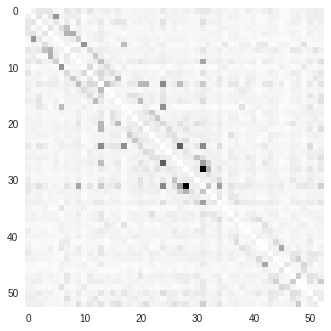

In [11]:
plt.imshow(DI+DI.T)
plt.grid(False)

#matlab DCA


##import DCA results

In [0]:
#@title import DCA results from matlab
%%writefile DI.out
1 2 0.208637 0.0421094
1 3 0.232461 0.0616165
1 4 0.201484 0.0660825
1 5 0.214093 0.0643543
1 6 0.127977 0.0239481
1 7 0.0180789 0.0182192
1 8 0.23506 0.0629391
1 9 0.18479 0.044659
1 10 0.281316 0.0650313
1 11 0.107633 0.032317
1 12 0.26209 0.0675445
1 13 0.188042 0.0348629
1 14 0.296219 0.0455303
1 15 0.176575 0.0531228
1 16 0.179933 0.0339391
1 17 0.232251 0.0528568
1 18 0.074043 0.0241899
1 19 0.168112 0.0261985
1 20 0.188937 0.0407583
1 21 0.203939 0.0318339
1 22 0.177721 0.0326413
1 23 0.172743 0.0377842
1 24 0.156303 0.0278021
1 25 0.192045 0.0603504
1 26 0.196635 0.0376951
1 27 0.219117 0.0437466
1 28 0.226241 0.0369221
1 29 0.290429 0.0481224
1 30 0.146711 0.0293731
1 31 0.20438 0.0560956
1 32 0.389566 0.0654735
1 33 0.258351 0.0613762
1 34 0.18836 0.040359
1 35 0.254685 0.0445982
1 36 0.09826 0.0352383
1 37 0.191027 0.0319455
1 38 0.192477 0.0380387
1 39 0.130421 0.0204723
1 40 0.207078 0.0522749
1 41 0.199317 0.0351901
1 42 0.122014 0.0284622
1 43 0.158727 0.0437251
1 44 0.249028 0.0611397
1 45 0.178062 0.0387398
1 46 0.109354 0.0212588
1 47 0.106354 0.0172174
1 48 0.170904 0.0379935
1 49 0.233008 0.0384289
1 50 0.0848804 0.0360747
1 51 0.217258 0.0467412
1 52 0.222983 0.054389
1 53 0.229783 0.0477538
2 3 0.203729 0.0704027
2 4 0.105785 0.0213065
2 5 0.144713 0.0745617
2 6 0.287043 0.184663
2 7 0.0128207 0.038218
2 8 0.172704 0.0476884
2 9 0.150175 0.0512657
2 10 0.236394 0.0452815
2 11 0.052502 0.00859381
2 12 0.134866 0.0300566
2 13 0.141651 0.0378794
2 14 0.203746 0.0318397
2 15 0.114919 0.0287646
2 16 0.165479 0.0319204
2 17 0.162975 0.0432991
2 18 0.0974261 0.0316545
2 19 0.154485 0.0271872
2 20 0.165802 0.0286674
2 21 0.18576 0.0370523
2 22 0.183393 0.0432217
2 23 0.156421 0.0311636
2 24 0.12388 0.0240432
2 25 0.172425 0.0234723
2 26 0.170079 0.039604
2 27 0.17383 0.0382985
2 28 0.19544 0.0324279
2 29 0.195259 0.0279519
2 30 0.121625 0.0245356
2 31 0.126186 0.0192892
2 32 0.292067 0.050083
2 33 0.179296 0.034845
2 34 0.139909 0.0279441
2 35 0.202315 0.0452763
2 36 0.0958743 0.0233911
2 37 0.189499 0.0432168
2 38 0.161454 0.0408312
2 39 0.101807 0.0250073
2 40 0.111461 0.0199522
2 41 0.149999 0.0413176
2 42 0.122641 0.0168154
2 43 0.113349 0.0181368
2 44 0.175548 0.0383526
2 45 0.14124 0.0351318
2 46 0.0977826 0.0224431
2 47 0.0901134 0.017136
2 48 0.183194 0.0350606
2 49 0.195576 0.0515389
2 50 0.078102 0.0294852
2 51 0.233833 0.046576
2 52 0.126635 0.0523367
2 53 0.213473 0.0446714
3 4 0.143263 0.046348
3 5 0.121948 0.0282724
3 6 0.210181 0.0685932
3 7 0.00658888 0.0220165
3 8 0.19237 0.0599253
3 9 0.184717 0.0212963
3 10 0.309147 0.0727574
3 11 0.0677518 0.0200481
3 12 0.187695 0.0432238
3 13 0.237075 0.0368854
3 14 0.404907 0.0601137
3 15 0.183676 0.0246231
3 16 0.23167 0.0587485
3 17 0.284872 0.0710455
3 18 0.0810093 0.065333
3 19 0.171368 0.0249741
3 20 0.218696 0.0353862
3 21 0.274196 0.0413702
3 22 0.162699 0.0346689
3 23 0.164318 0.0356048
3 24 0.167615 0.0256602
3 25 0.362749 0.0714043
3 26 0.153726 0.0292672
3 27 0.254638 0.0443854
3 28 0.351656 0.0349624
3 29 0.277484 0.0368713
3 30 0.121564 0.0229054
3 31 0.233543 0.0270876
3 32 0.447238 0.0780861
3 33 0.236725 0.0376565
3 34 0.167724 0.043332
3 35 0.214562 0.0487837
3 36 0.0947626 0.0260763
3 37 0.172294 0.0280605
3 38 0.172494 0.0308717
3 39 0.116613 0.0211222
3 40 0.137363 0.0218976
3 41 0.154434 0.032176
3 42 0.129907 0.0169523
3 43 0.123316 0.0192883
3 44 0.221442 0.0354027
3 45 0.146297 0.0283941
3 46 0.085908 0.00994458
3 47 0.0860216 0.0231537
3 48 0.168242 0.0483334
3 49 0.250014 0.046474
3 50 0.0861924 0.0160235
3 51 0.294139 0.0553671
3 52 0.182904 0.0343693
3 53 0.315758 0.0522529
4 5 0.11189 0.0716963
4 6 0.0694502 0.0220623
4 7 0.0130055 0.0842451
4 8 0.194477 0.130945
4 9 0.0689238 0.0171516
4 10 0.173216 0.0409924
4 11 0.041988 0.0248689
4 12 0.0777724 0.0270535
4 13 0.0795549 0.0140678
4 14 0.158543 0.0457118
4 15 0.0807883 0.0250595
4 16 0.119983 0.0222476
4 17 0.0911363 0.0262533
4 18 0.053959 0.041343
4 19 0.0721509 0.0222634
4 20 0.0679944 0.0192907
4 21 0.108222 0.0234096
4 22 0.111918 0.0219705
4 23 0.093974 0.0428947
4 24 0.0723047 0.0230214
4 25 0.121471 0.0522711
4 26 0.0694206 0.0259146
4 27 0.121739 0.0431473
4 28 0.118249 0.0153746
4 29 0.143785 0.0260974
4 30 0.0754818 0.0244218
4 31 0.0927305 0.0221489
4 32 0.227108 0.0487733
4 33 0.10498 0.0279817
4 34 0.08262 0.0177668
4 35 0.138166 0.0394986
4 36 0.0731324 0.0379853
4 37 0.125822 0.0341254
4 38 0.0888122 0.0315398
4 39 0.051501 0.019089
4 40 0.0765294 0.03693
4 41 0.0853317 0.0271797
4 42 0.0713032 0.0199011
4 43 0.0657181 0.0204234
4 44 0.0892304 0.0317003
4 45 0.0875949 0.0296941
4 46 0.0559438 0.0114359
4 47 0.0609349 0.0261329
4 48 0.108184 0.025589
4 49 0.100759 0.0207431
4 50 0.0443881 0.019351
4 51 0.122191 0.0328837
4 52 0.103114 0.0387776
4 53 0.141761 0.0340366
5 6 0.0887815 0.0297383
5 7 0.00624703 0.0412112
5 8 0.221617 0.150607
5 9 0.242093 0.157717
5 10 0.180909 0.053618
5 11 0.036713 0.0290003
5 12 0.112348 0.0328592
5 13 0.143795 0.0403475
5 14 0.159407 0.0521063
5 15 0.118754 0.034165
5 16 0.149624 0.028256
5 17 0.105129 0.024284
5 18 0.0501559 0.0117421
5 19 0.118535 0.0319737
5 20 0.11529 0.0223317
5 21 0.13174 0.0256173
5 22 0.1132 0.0273235
5 23 0.140696 0.0288706
5 24 0.0777462 0.0169125
5 25 0.0917906 0.0250278
5 26 0.117516 0.025789
5 27 0.152934 0.0255809
5 28 0.108954 0.0246898
5 29 0.153109 0.0224583
5 30 0.105782 0.0208511
5 31 0.119477 0.0258898
5 32 0.200858 0.0209813
5 33 0.139936 0.029329
5 34 0.126513 0.0355317
5 35 0.14043 0.0338348
5 36 0.0532134 0.0118207
5 37 0.162941 0.0350288
5 38 0.110116 0.0390472
5 39 0.0666818 0.0176371
5 40 0.108578 0.0152765
5 41 0.124126 0.0272744
5 42 0.0793558 0.0207357
5 43 0.120903 0.0478304
5 44 0.124269 0.0323561
5 45 0.107113 0.0293443
5 46 0.103867 0.0226489
5 47 0.075129 0.0218472
5 48 0.127219 0.0435645
5 49 0.140804 0.0295843
5 50 0.056735 0.0103079
5 51 0.166029 0.0441518
5 52 0.109278 0.024026
5 53 0.145301 0.03263
6 7 0.0070449 0.0263662
6 8 0.102982 0.0444826
6 9 0.127306 0.0545991
6 10 0.295428 0.106835
6 11 0.0525142 0.0135363
6 12 0.123701 0.0321079
6 13 0.106152 0.0504496
6 14 0.226549 0.0515199
6 15 0.103483 0.0278217
6 16 0.104889 0.0212309
6 17 0.169438 0.0431227
6 18 0.069108 0.0357882
6 19 0.119521 0.0231196
6 20 0.127818 0.0282086
6 21 0.163874 0.0335453
6 22 0.105662 0.039116
6 23 0.122957 0.0303989
6 24 0.116213 0.0356499
6 25 0.184499 0.0250574
6 26 0.11833 0.0360334
6 27 0.141031 0.0349948
6 28 0.182317 0.0411998
6 29 0.149849 0.0322874
6 30 0.105887 0.0205109
6 31 0.129506 0.0244087
6 32 0.224465 0.0366691
6 33 0.136938 0.0298614
6 34 0.0894179 0.0227544
6 35 0.141791 0.0325754
6 36 0.0706052 0.0186385
6 37 0.116352 0.030734
6 38 0.144777 0.0359325
6 39 0.0663818 0.029681
6 40 0.0922202 0.0204939
6 41 0.106455 0.0236325
6 42 0.0809689 0.0146762
6 43 0.0940225 0.0185044
6 44 0.131142 0.0239357
6 45 0.0965288 0.0201599
6 46 0.0712711 0.0131873
6 47 0.050459 0.0141568
6 48 0.122997 0.0250306
6 49 0.128317 0.0322145
6 50 0.0578999 0.0221275
6 51 0.145599 0.0218454
6 52 0.102881 0.0272209
6 53 0.153946 0.0220481
7 8 0.0104268 0.0357726
7 9 0.00725537 0.0158185
7 10 0.00548727 0.0106717
7 11 0.000738467 0.189173
7 12 0.01184 0.0256828
7 13 0.00817766 0.0106676
7 14 0.0198507 0.0274707
7 15 0.00272319 0.0329539
7 16 0.013205 0.0206326
7 17 0.0102719 0.0160148
7 18 0.000590019 0.141055
7 19 0.024106 0.0400711
7 20 0.0105792 0.0139371
7 21 0.0133261 0.0247483
7 22 0.0125893 0.0406081
7 23 0.0121235 0.0191743
7 24 0.0113439 0.0389187
7 25 0.00333017 0.0513103
7 26 0.0140192 0.0255471
7 27 0.0149275 0.0140035
7 28 0.0179956 0.018414
7 29 0.0173186 0.0317937
7 30 0.00747546 0.0132
7 31 0.00951011 0.0204263
7 32 0.00744319 0.0191247
7 33 0.0166081 0.0466404
7 34 0.0128174 0.0250651
7 35 0.0108893 0.0107354
7 36 0.00142094 0.0659895
7 37 0.0119862 0.0111078
7 38 0.00859136 0.0170229
7 39 0.00146909 0.0452947
7 40 0.00423949 0.0444521
7 41 0.0119553 0.0158058
7 42 0.00268809 0.0545068
7 43 0.00877711 0.0624193
7 44 0.0153232 0.0154337
7 45 0.0143923 0.0192293
7 46 0.00141404 0.043572
7 47 0.00253463 0.0367885
7 48 0.00936146 0.0158513
7 49 0.0140867 0.0236227
7 50 0.000555368 0.0731822
7 51 0.00512085 0.017776
7 52 0.0148785 0.0168905
7 53 0.00550874 0.0260609
8 9 0.175531 0.0570721
8 10 0.230432 0.0556916
8 11 0.0522904 0.0181079
8 12 0.207022 0.0876571
8 13 0.165976 0.0437155
8 14 0.221206 0.0532412
8 15 0.159964 0.0490875
8 16 0.186225 0.0379218
8 17 0.13946 0.0357716
8 18 0.0785656 0.0360245
8 19 0.119661 0.0240703
8 20 0.116081 0.0286484
8 21 0.15877 0.0395591
8 22 0.152896 0.0359719
8 23 0.153888 0.0465256
8 24 0.10769 0.0201287
8 25 0.166407 0.0393977
8 26 0.118824 0.0306494
8 27 0.184232 0.0313701
8 28 0.192924 0.0359715
8 29 0.244146 0.0354015
8 30 0.114624 0.0237781
8 31 0.15375 0.0399984
8 32 0.32026 0.0694668
8 33 0.169202 0.0324651
8 34 0.128696 0.0350472
8 35 0.190031 0.0508925
8 36 0.0962199 0.021132
8 37 0.151872 0.0393754
8 38 0.116161 0.029797
8 39 0.0958095 0.0373419
8 40 0.126624 0.0299191
8 41 0.15877 0.0461068
8 42 0.118793 0.0515603
8 43 0.110777 0.0385467
8 44 0.179008 0.0445666
8 45 0.147668 0.0516271
8 46 0.0993454 0.0298888
8 47 0.068388 0.0207401
8 48 0.169632 0.0629661
8 49 0.233963 0.0610174
8 50 0.0622382 0.0289735
8 51 0.227794 0.043544
8 52 0.175008 0.0740812
8 53 0.191308 0.0465287
9 10 0.174433 0.0302138
9 11 0.0580292 0.025806
9 12 0.13993 0.0319968
9 13 0.254819 0.119304
9 14 0.233408 0.0494891
9 15 0.128914 0.022399
9 16 0.150021 0.0432273
9 17 0.180547 0.0351069
9 18 0.0448181 0.0221763
9 19 0.105814 0.0293195
9 20 0.148804 0.0304171
9 21 0.156484 0.0288914
9 22 0.140771 0.0396301
9 23 0.148364 0.0332399
9 24 0.11262 0.0325406
9 25 0.206196 0.0482456
9 26 0.112729 0.0317824
9 27 0.202667 0.0345928
9 28 0.213774 0.0298929
9 29 0.208298 0.0292761
9 30 0.121842 0.0276536
9 31 0.147918 0.0235963
9 32 0.268571 0.0409862
9 33 0.167365 0.0330858
9 34 0.126846 0.0312024
9 35 0.122791 0.0341789
9 36 0.0757246 0.0284191
9 37 0.123325 0.0265474
9 38 0.123025 0.0307691
9 39 0.0751311 0.0279353
9 40 0.141299 0.02483
9 41 0.121287 0.0249779
9 42 0.0983612 0.0146187
9 43 0.0981048 0.0239211
9 44 0.167475 0.0378153
9 45 0.105558 0.0259545
9 46 0.0856051 0.0269788
9 47 0.0691418 0.0132759
9 48 0.121664 0.0280725
9 49 0.176389 0.0272152
9 50 0.0639971 0.0179838
9 51 0.191329 0.0280469
9 52 0.133487 0.0343805
9 53 0.185725 0.0274356
10 11 0.0780532 0.0244334
10 12 0.228359 0.0440731
10 13 0.212929 0.0513943
10 14 0.4861 0.136842
10 15 0.203243 0.0538931
10 16 0.215091 0.0368107
10 17 0.267241 0.0437494
10 18 0.0928666 0.0271696
10 19 0.23919 0.0528952
10 20 0.238506 0.047004
10 21 0.310815 0.0708843
10 22 0.22475 0.0472662
10 23 0.202759 0.0382879
10 24 0.169621 0.050795
10 25 0.24754 0.0524801
10 26 0.217204 0.0426512
10 27 0.252689 0.0347036
10 28 0.284186 0.0389492
10 29 0.383448 0.0494332
10 30 0.222255 0.0347577
10 31 0.269206 0.0505747
10 32 0.547851 0.168003
10 33 0.301498 0.0457105
10 34 0.187142 0.0432975
10 35 0.310022 0.0546924
10 36 0.122769 0.033157
10 37 0.236042 0.0560583
10 38 0.181745 0.035188
10 39 0.140682 0.036656
10 40 0.192597 0.0361744
10 41 0.229755 0.0485705
10 42 0.130821 0.011792
10 43 0.224254 0.055233
10 44 0.310376 0.053632
10 45 0.19909 0.0282494
10 46 0.150341 0.0319676
10 47 0.112517 0.0258074
10 48 0.229338 0.0374412
10 49 0.233453 0.043511
10 50 0.100755 0.0355959
10 51 0.277935 0.0590819
10 52 0.177558 0.0386521
10 53 0.334243 0.0778572
11 12 0.113187 0.0906552
11 13 0.0739974 0.0170778
11 14 0.112643 0.0558927
11 15 0.0999024 0.0850891
11 16 0.0856891 0.0419323
11 17 0.0634109 0.0131604
11 18 0.0369684 0.047798
11 19 0.059781 0.0216241
11 20 0.0577575 0.0227307
11 21 0.0598201 0.0236677
11 22 0.0595646 0.0198067
11 23 0.0531094 0.0132287
11 24 0.0404237 0.0127464
11 25 0.0797648 0.0317176
11 26 0.0409231 0.0116483
11 27 0.066055 0.025702
11 28 0.0824049 0.0345809
11 29 0.0888603 0.0242398
11 30 0.0563637 0.0209931
11 31 0.066941 0.0139604
11 32 0.106493 0.0267291
11 33 0.0611166 0.018476
11 34 0.043401 0.0104656
11 35 0.0879574 0.0353001
11 36 0.0524595 0.0475747
11 37 0.0614021 0.0170142
11 38 0.0431791 0.0201723
11 39 0.0284305 0.0258741
11 40 0.0468042 0.0111419
11 41 0.0519598 0.020233
11 42 0.0478228 0.0164927
11 43 0.0382207 0.0200587
11 44 0.0670564 0.0224638
11 45 0.0416328 0.0120296
11 46 0.0475175 0.0420182
11 47 0.0401621 0.0276405
11 48 0.0461658 0.0150982
11 49 0.0550431 0.0192575
11 50 0.0394151 0.0556306
11 51 0.0823679 0.0221882
11 52 0.047271 0.0153246
11 53 0.0987749 0.0342921
12 13 0.206786 0.0694516
12 14 0.322546 0.0965694
12 15 0.154538 0.0591539
12 16 0.249535 0.0850846
12 17 0.255909 0.0483347
12 18 0.069418 0.0294457
12 19 0.17983 0.0325744
12 20 0.194845 0.0408455
12 21 0.215067 0.0359454
12 22 0.137047 0.0353526
12 23 0.17154 0.0290852
12 24 0.14834 0.0241249
12 25 0.158283 0.0212209
12 26 0.163516 0.0534758
12 27 0.245502 0.042427
12 28 0.281507 0.0546176
12 29 0.277896 0.0326915
12 30 0.146447 0.0397165
12 31 0.16545 0.0253434
12 32 0.331858 0.0752993
12 33 0.192115 0.0297369
12 34 0.141978 0.0298198
12 35 0.194548 0.0373747
12 36 0.0850877 0.0169727
12 37 0.165433 0.0325235
12 38 0.142861 0.03345
12 39 0.110812 0.0284626
12 40 0.153653 0.0354296
12 41 0.164656 0.0379377
12 42 0.0925905 0.0258964
12 43 0.113378 0.0264446
12 44 0.264265 0.0478631
12 45 0.156406 0.0313304
12 46 0.0862729 0.0122391
12 47 0.0978841 0.0281859
12 48 0.166766 0.0543391
12 49 0.235031 0.049967
12 50 0.0781331 0.0159938
12 51 0.202056 0.0346263
12 52 0.187275 0.0443726
12 53 0.267792 0.061499
13 14 0.354245 0.0870208
13 15 0.200448 0.0461511
13 16 0.194029 0.0340341
13 17 0.326107 0.141493
13 18 0.0781128 0.0149444
13 19 0.182964 0.0307483
13 20 0.210036 0.05017
13 21 0.242901 0.0506912
13 22 0.182747 0.028767
13 23 0.171121 0.0345448
13 24 0.150183 0.0274565
13 25 0.242196 0.0520353
13 26 0.145026 0.0332309
13 27 0.236537 0.0427517
13 28 0.302171 0.0421234
13 29 0.214061 0.029048
13 30 0.1182 0.0214904
13 31 0.167536 0.0235228
13 32 0.311221 0.0281
13 33 0.216332 0.0426153
13 34 0.140877 0.028388
13 35 0.219133 0.0626471
13 36 0.0851421 0.022287
13 37 0.201886 0.0382824
13 38 0.161261 0.0441781
13 39 0.0733874 0.0168507
13 40 0.186265 0.0476183
13 41 0.169505 0.0465726
13 42 0.135381 0.0266051
13 43 0.126787 0.0244441
13 44 0.18028 0.0302942
13 45 0.155048 0.0384962
13 46 0.0840585 0.0194146
13 47 0.0879773 0.0254893
13 48 0.131354 0.0328514
13 49 0.213474 0.0515074
13 50 0.0764403 0.0179604
13 51 0.253911 0.0313995
13 52 0.208533 0.070143
13 53 0.264057 0.0487188
14 15 0.347767 0.141592
14 16 0.333997 0.0855084
14 17 0.360387 0.0595394
14 18 0.0954726 0.0316249
14 19 0.27398 0.0625788
14 20 0.282393 0.0571841
14 21 0.453941 0.144929
14 22 0.382064 0.148668
14 23 0.217115 0.0317201
14 24 0.198925 0.0326884
14 25 0.517731 0.20214
14 26 0.191177 0.0403506
14 27 0.340747 0.0549922
14 28 0.531536 0.138334
14 29 0.413304 0.0561459
14 30 0.175108 0.0285598
14 31 0.321586 0.0561808
14 32 0.611081 0.11458
14 33 0.317242 0.0304614
14 34 0.170306 0.037084
14 35 0.25497 0.0570585
14 36 0.0980105 0.0218931
14 37 0.257479 0.0645452
14 38 0.276724 0.0654628
14 39 0.137179 0.0195439
14 40 0.240245 0.0576503
14 41 0.16342 0.0353092
14 42 0.158135 0.0193093
14 43 0.211567 0.0632104
14 44 0.335187 0.0680651
14 45 0.155828 0.0348155
14 46 0.142653 0.0546929
14 47 0.0913176 0.011651
14 48 0.241471 0.0323071
14 49 0.312881 0.0505069
14 50 0.0913817 0.0217241
14 51 0.385995 0.0632584
14 52 0.207981 0.0255539
14 53 0.385718 0.0700062
15 16 0.166173 0.0202136
15 17 0.175192 0.0272013
15 18 0.0641151 0.0294783
15 19 0.113632 0.0258622
15 20 0.151014 0.0232643
15 21 0.190944 0.0175453
15 22 0.166137 0.0366201
15 23 0.112971 0.0263156
15 24 0.088446 0.0274341
15 25 0.237303 0.0610176
15 26 0.0939539 0.0234064
15 27 0.177179 0.0292728
15 28 0.263248 0.0278731
15 29 0.244447 0.0448725
15 30 0.094151 0.0205875
15 31 0.165503 0.036292
15 32 0.312865 0.0500712
15 33 0.19195 0.0428513
15 34 0.080745 0.0196048
15 35 0.151505 0.0334999
15 36 0.0554801 0.0171985
15 37 0.124191 0.0179115
15 38 0.139033 0.0386399
15 39 0.0755521 0.0571519
15 40 0.135276 0.041533
15 41 0.0991935 0.0238761
15 42 0.0916484 0.00971238
15 43 0.102537 0.0228303
15 44 0.15702 0.0389647
15 45 0.105339 0.0253755
15 46 0.101763 0.0320395
15 47 0.0581919 0.0103432
15 48 0.11712 0.0383051
15 49 0.144796 0.0339601
15 50 0.063928 0.024682
15 51 0.191466 0.0319816
15 52 0.108032 0.0313015
15 53 0.196505 0.0335357
16 17 0.239682 0.0428343
16 18 0.0885696 0.0297125
16 19 0.178242 0.075867
16 20 0.254992 0.0765467
16 21 0.261047 0.0603606
16 22 0.18238 0.0378539
16 23 0.175415 0.0470055
16 24 0.15524 0.0366575
16 25 0.278367 0.0676993
16 26 0.14444 0.0308888
16 27 0.244561 0.0366926
16 28 0.275703 0.0386399
16 29 0.24412 0.0294416
16 30 0.136974 0.0371104
16 31 0.218232 0.0502657
16 32 0.384645 0.0557805
16 33 0.172586 0.0312984
16 34 0.172324 0.0369185
16 35 0.189085 0.0429778
16 36 0.103204 0.0180472
16 37 0.193401 0.0378685
16 38 0.145624 0.0319925
16 39 0.121103 0.0418108
16 40 0.137309 0.0334726
16 41 0.161127 0.0385851
16 42 0.120387 0.0285314
16 43 0.135055 0.0395376
16 44 0.172162 0.0293554
16 45 0.149129 0.0338458
16 46 0.108183 0.0225852
16 47 0.0638638 0.0142167
16 48 0.14318 0.0279005
16 49 0.189914 0.0387478
16 50 0.0676907 0.022296
16 51 0.254746 0.0665807
16 52 0.178981 0.0321751
16 53 0.29941 0.0695008
17 18 0.104626 0.0334525
17 19 0.24152 0.0476134
17 20 0.254812 0.0513962
17 21 0.398787 0.142726
17 22 0.173398 0.0389538
17 23 0.232848 0.0503069
17 24 0.174488 0.0312225
17 25 0.291042 0.0673689
17 26 0.187819 0.0403586
17 27 0.221822 0.0351034
17 28 0.336009 0.0584909
17 29 0.289762 0.0482339
17 30 0.183691 0.0377651
17 31 0.226201 0.0385614
17 32 0.460924 0.0864449
17 33 0.222982 0.0342479
17 34 0.135079 0.0339242
17 35 0.220202 0.0444901
17 36 0.107683 0.0272842
17 37 0.190428 0.0313494
17 38 0.196729 0.0456571
17 39 0.125583 0.0224157
17 40 0.209123 0.0388563
17 41 0.174619 0.0366488
17 42 0.151783 0.0268222
17 43 0.159277 0.0290305
17 44 0.233264 0.0454344
17 45 0.158192 0.0369761
17 46 0.114096 0.0194494
17 47 0.0921074 0.0153866
17 48 0.186025 0.037619
17 49 0.224188 0.0444626
17 50 0.0884973 0.0188746
17 51 0.259291 0.0339641
17 52 0.221458 0.0371715
17 53 0.324606 0.078865
18 19 0.0614162 0.0170495
18 20 0.0688202 0.0175088
18 21 0.0783047 0.020651
18 22 0.0913645 0.0474904
18 23 0.0734323 0.0169083
18 24 0.0490559 0.0139376
18 25 0.129579 0.194092
18 26 0.0855256 0.0322515
18 27 0.0772284 0.0133824
18 28 0.0769068 0.014584
18 29 0.0658818 0.0120788
18 30 0.0702016 0.014216
18 31 0.0772995 0.0174629
18 32 0.106236 0.0272482
18 33 0.0824601 0.0157983
18 34 0.0650941 0.0127518
18 35 0.0913846 0.0283758
18 36 0.0313171 0.0121098
18 37 0.0684131 0.0155221
18 38 0.070602 0.0133387
18 39 0.057725 0.0731787
18 40 0.0495405 0.0177297
18 41 0.0851067 0.0282539
18 42 0.0613831 0.0410601
18 43 0.0548604 0.0220799
18 44 0.0858519 0.0366756
18 45 0.0868481 0.0320691
18 46 0.0344433 0.00942924
18 47 0.0311187 0.0164886
18 48 0.066434 0.0160957
18 49 0.104517 0.030709
18 50 0.0487037 0.0350801
18 51 0.0750644 0.0655486
18 52 0.0654819 0.0234542
18 53 0.0875635 0.0393554
19 20 0.186541 0.0428125
19 21 0.193302 0.0516867
19 22 0.187058 0.0705027
19 23 0.289622 0.115028
19 24 0.153075 0.041569
19 25 0.16089 0.0255414
19 26 0.156061 0.0308876
19 27 0.189676 0.0371604
19 28 0.220227 0.0320351
19 29 0.222178 0.0407908
19 30 0.136244 0.0421493
19 31 0.153507 0.0405523
19 32 0.26694 0.0392424
19 33 0.204468 0.0375109
19 34 0.126341 0.0247985
19 35 0.200551 0.0411004
19 36 0.0768544 0.0192528
19 37 0.183281 0.0325168
19 38 0.144483 0.0345204
19 39 0.0714206 0.0205385
19 40 0.142812 0.0351492
19 41 0.163324 0.0397231
19 42 0.0739904 0.0113861
19 43 0.155196 0.0454388
19 44 0.208705 0.0420377
19 45 0.170331 0.0364874
19 46 0.0956571 0.0179686
19 47 0.108184 0.0310805
19 48 0.15285 0.0355537
19 49 0.177432 0.0332424
19 50 0.0782467 0.0457487
19 51 0.22196 0.0454123
19 52 0.183907 0.0429773
19 53 0.210907 0.045668
20 21 0.256189 0.0542491
20 22 0.170217 0.0456216
20 23 0.237222 0.0630093
20 24 0.271931 0.118366
20 25 0.241421 0.0430095
20 26 0.153444 0.0262989
20 27 0.229241 0.0458109
20 28 0.291476 0.0334299
20 29 0.226595 0.0608185
20 30 0.172195 0.0405351
20 31 0.20816 0.03995
20 32 0.305944 0.049146
20 33 0.221616 0.0398508
20 34 0.145459 0.0312781
20 35 0.187708 0.0433174
20 36 0.0692483 0.0147503
20 37 0.214082 0.0414584
20 38 0.21764 0.0423953
20 39 0.0832619 0.0174733
20 40 0.133924 0.025172
20 41 0.15563 0.0497832
20 42 0.126528 0.018565
20 43 0.124682 0.0228061
20 44 0.212108 0.0470201
20 45 0.185438 0.033893
20 46 0.0896271 0.014846
20 47 0.0877387 0.0165883
20 48 0.150276 0.0283748
20 49 0.199528 0.0407986
20 50 0.0763427 0.0209314
20 51 0.244387 0.034856
20 52 0.220806 0.0498014
20 53 0.263392 0.0296613
21 22 0.271732 0.0746745
21 23 0.198751 0.0461226
21 24 0.181469 0.0640621
21 25 0.361065 0.0936762
21 26 0.203179 0.0496227
21 27 0.28138 0.0397566
21 28 0.381357 0.0745529
21 29 0.356213 0.049046
21 30 0.17845 0.0397517
21 31 0.295287 0.0788777
21 32 0.379288 0.0634885
21 33 0.268979 0.044811
21 34 0.179029 0.0379311
21 35 0.213792 0.0553648
21 36 0.103143 0.0275712
21 37 0.189982 0.0298433
21 38 0.156828 0.035146
21 39 0.0997113 0.0346039
21 40 0.213847 0.0333529
21 41 0.194599 0.0386024
21 42 0.149258 0.0294669
21 43 0.155749 0.0311589
21 44 0.240091 0.0481151
21 45 0.189707 0.0362897
21 46 0.101098 0.0170962
21 47 0.100997 0.0416986
21 48 0.226975 0.0683183
21 49 0.217508 0.0289854
21 50 0.0828881 0.0319974
21 51 0.302535 0.0444396
21 52 0.204838 0.0341069
21 53 0.307035 0.0514997
22 23 0.186695 0.047287
22 24 0.169583 0.0564615
22 25 0.240554 0.0341095
22 26 0.192461 0.0853821
22 27 0.230344 0.0401968
22 28 0.279111 0.0445341
22 29 0.293512 0.0698347
22 30 0.140639 0.0465711
22 31 0.170298 0.0327848
22 32 0.367588 0.0405967
22 33 0.247118 0.044859
22 34 0.148105 0.0250743
22 35 0.219385 0.0481429
22 36 0.0580088 0.0237314
22 37 0.157671 0.0319256
22 38 0.152547 0.0318724
22 39 0.0847536 0.0163085
22 40 0.164559 0.0312213
22 41 0.160766 0.028089
22 42 0.144881 0.0347884
22 43 0.168102 0.044709
22 44 0.15988 0.0259535
22 45 0.140386 0.0261319
22 46 0.101408 0.0241637
22 47 0.0664235 0.0113473
22 48 0.139022 0.0321969
22 49 0.219922 0.0351379
22 50 0.0653898 0.0318962
22 51 0.289962 0.0594619
22 52 0.132949 0.0268926
22 53 0.279095 0.0811945
23 24 0.169235 0.0408739
23 25 0.220251 0.0389911
23 26 0.202826 0.0693668
23 27 0.295804 0.0780154
23 28 0.223826 0.0323406
23 29 0.233236 0.0422006
23 30 0.208068 0.0500323
23 31 0.204612 0.0496644
23 32 0.310054 0.053922
23 33 0.237109 0.0415264
23 34 0.143293 0.0374272
23 35 0.203347 0.0473643
23 36 0.0771554 0.0142744
23 37 0.241254 0.0787071
23 38 0.19907 0.0421255
23 39 0.0879773 0.0260287
23 40 0.175861 0.0355118
23 41 0.173131 0.0306793
23 42 0.113216 0.0202881
23 43 0.115019 0.0146769
23 44 0.207604 0.0509486
23 45 0.169441 0.0435711
23 46 0.121745 0.0370875
23 47 0.100422 0.0210645
23 48 0.194001 0.0383836
23 49 0.214882 0.0401265
23 50 0.0706254 0.0213571
23 51 0.280176 0.0395905
23 52 0.178711 0.046699
23 53 0.232548 0.0350872
24 25 0.181227 0.0433419
24 26 0.130635 0.0261103
24 27 0.222142 0.0764011
24 28 0.247608 0.0578003
24 29 0.230696 0.0794841
24 30 0.12772 0.0321655
24 31 0.144541 0.0288582
24 32 0.286923 0.0503967
24 33 0.205054 0.0532814
24 34 0.141292 0.0353519
24 35 0.162877 0.0354091
24 36 0.0760722 0.0170866
24 37 0.157953 0.0276801
24 38 0.153184 0.0380563
24 39 0.0851279 0.0152558
24 40 0.113723 0.0302447
24 41 0.159611 0.032726
24 42 0.0779079 0.00995782
24 43 0.108709 0.0205243
24 44 0.150421 0.0442365
24 45 0.124253 0.0306612
24 46 0.0688442 0.0148972
24 47 0.0717789 0.0165382
24 48 0.140827 0.0373996
24 49 0.143449 0.022007
24 50 0.0543601 0.0112769
24 51 0.202048 0.0322818
24 52 0.173792 0.0312467
24 53 0.184006 0.0296111
25 26 0.150625 0.0340755
25 27 0.329458 0.0569655
25 28 0.513546 0.263304
25 29 0.361789 0.0479611
25 30 0.137103 0.0333325
25 31 0.31742 0.0667921
25 32 0.531793 0.204488
25 33 0.253849 0.0241723
25 34 0.134084 0.023325
25 35 0.236397 0.0825173
25 36 0.0801794 0.0187445
25 37 0.178374 0.0290221
25 38 0.212332 0.0390389
25 39 0.0900945 0.0275878
25 40 0.1709 0.0258968
25 41 0.157107 0.0348241
25 42 0.182303 0.036396
25 43 0.134485 0.0593755
25 44 0.170859 0.0256847
25 45 0.124397 0.035035
25 46 0.0961218 0.0280777
25 47 0.0753709 0.0241843
25 48 0.158693 0.0412909
25 49 0.246858 0.0367229
25 50 0.0636438 0.0196501
25 51 0.376163 0.0857309
25 52 0.132782 0.0148749
25 53 0.298985 0.0391766
26 27 0.199324 0.0534458
26 28 0.184909 0.0380897
26 29 0.237652 0.0656626
26 30 0.167262 0.0422981
26 31 0.137484 0.0266659
26 32 0.223934 0.037372
26 33 0.186953 0.0437407
26 34 0.156147 0.0324122
26 35 0.212123 0.0412636
26 36 0.0818608 0.0145553
26 37 0.223359 0.0543419
26 38 0.161264 0.0296061
26 39 0.0928621 0.0355712
26 40 0.131546 0.0306322
26 41 0.165506 0.0330214
26 42 0.0919494 0.0201372
26 43 0.169672 0.0296561
26 44 0.182617 0.0423108
26 45 0.159167 0.02941
26 46 0.128881 0.0272402
26 47 0.0882874 0.0186363
26 48 0.177443 0.0369568
26 49 0.177339 0.0304533
26 50 0.0939439 0.0308899
26 51 0.20795 0.0519413
26 52 0.178406 0.0487626
26 53 0.210464 0.0510117
27 28 0.329604 0.0294776
27 29 0.290126 0.0500293
27 30 0.201648 0.056122
27 31 0.361153 0.128254
27 32 0.432256 0.0823025
27 33 0.284417 0.0394571
27 34 0.177595 0.044824
27 35 0.222393 0.0429016
27 36 0.0854728 0.0178805
27 37 0.248802 0.049999
27 38 0.213676 0.0512109
27 39 0.124283 0.0304324
27 40 0.242055 0.0604723
27 41 0.180625 0.0428939
27 42 0.157559 0.0198699
27 43 0.160173 0.0347591
27 44 0.265006 0.0550297
27 45 0.175474 0.0344368
27 46 0.10123 0.0221758
27 47 0.100193 0.0321878
27 48 0.197362 0.0505308
27 49 0.273275 0.0329031
27 50 0.0840033 0.0131279
27 51 0.336564 0.0550653
27 52 0.200905 0.0461581
27 53 0.335142 0.0794671
28 29 0.344472 0.0397178
28 30 0.174862 0.040518
28 31 0.307581 0.0490285
28 32 0.580908 0.174551
28 33 0.35265 0.105693
28 34 0.178435 0.0378934
28 35 0.222077 0.0463227
28 36 0.123085 0.0460538
28 37 0.228261 0.037987
28 38 0.208966 0.0426684
28 39 0.115326 0.0227553
28 40 0.2124 0.031317
28 41 0.158452 0.046792
28 42 0.170132 0.0183017
28 43 0.141914 0.0635865
28 44 0.289877 0.0409862
28 45 0.183441 0.0336906
28 46 0.112738 0.0111099
28 47 0.0987823 0.0182982
28 48 0.222109 0.0523511
28 49 0.319686 0.0414093
28 50 0.0839423 0.0201159
28 51 0.383133 0.0403104
28 52 0.219883 0.0236754
28 53 0.359994 0.0560493
29 30 0.218741 0.0451258
29 31 0.301428 0.0623137
29 32 0.76916 0.372828
29 33 0.437255 0.154011
29 34 0.179734 0.0401575
29 35 0.325465 0.0710701
29 36 0.103053 0.0241421
29 37 0.249459 0.0437521
29 38 0.226091 0.0481781
29 39 0.161666 0.0290096
29 40 0.251127 0.0446116
29 41 0.201242 0.0464896
29 42 0.175317 0.0308638
29 43 0.172193 0.0332637
29 44 0.27875 0.0467518
29 45 0.195249 0.0372744
29 46 0.13524 0.0220405
29 47 0.112168 0.0268406
29 48 0.233579 0.0538048
29 49 0.289046 0.0599726
29 50 0.0880835 0.0306884
29 51 0.37797 0.0656603
29 52 0.193911 0.0323129
29 53 0.350011 0.0628152
30 31 0.187065 0.0567909
30 32 0.261592 0.0474704
30 33 0.233794 0.0802159
30 34 0.161498 0.0503512
30 35 0.19915 0.0469351
30 36 0.0882015 0.0179935
30 37 0.182408 0.0511143
30 38 0.178563 0.0411068
30 39 0.0841 0.0184612
30 40 0.108946 0.0286093
30 41 0.178943 0.0426624
30 42 0.0968954 0.0185218
30 43 0.132647 0.0266872
30 44 0.177069 0.0383973
30 45 0.173499 0.0441802
30 46 0.106368 0.0171084
30 47 0.0817423 0.0186898
30 48 0.170988 0.0409476
30 49 0.145615 0.0289134
30 50 0.090208 0.0259424
30 51 0.204984 0.0488385
30 52 0.161025 0.0413166
30 53 0.165135 0.0299906
31 32 0.391918 0.0458437
31 33 0.209554 0.0365852
31 34 0.173897 0.055695
31 35 0.243357 0.0917485
31 36 0.0896372 0.0228144
31 37 0.161641 0.0350283
31 38 0.165581 0.0308915
31 39 0.0788852 0.0131675
31 40 0.154171 0.0495471
31 41 0.166348 0.0407076
31 42 0.126688 0.0238105
31 43 0.133218 0.0309185
31 44 0.196655 0.0354521
31 45 0.137814 0.0398183
31 46 0.12793 0.0294744
31 47 0.0902442 0.0271273
31 48 0.215057 0.0619392
31 49 0.181131 0.0343456
31 50 0.0862611 0.0373456
31 51 0.313313 0.058784
31 52 0.170175 0.0342034
31 53 0.245044 0.0410322
32 33 0.482432 0.124566
32 34 0.197436 0.0315311
32 35 0.459201 0.175303
32 36 0.128069 0.0309576
32 37 0.352491 0.0743548
32 38 0.326367 0.053638
32 39 0.18889 0.0532763
32 40 0.287552 0.0585862
32 41 0.244735 0.0460365
32 42 0.234274 0.0403893
32 43 0.217274 0.0379133
32 44 0.360735 0.0540041
32 45 0.239721 0.0430484
32 46 0.171552 0.0555688
32 47 0.123872 0.0217952
32 48 0.258812 0.0299069
32 49 0.357322 0.0609933
32 50 0.145444 0.0641049
32 51 0.479207 0.056793
32 52 0.30025 0.0437431
32 53 0.483006 0.107319
33 34 0.15356 0.0372196
33 35 0.245864 0.0544597
33 36 0.0832227 0.0244147
33 37 0.239468 0.0590265
33 38 0.196323 0.02901
33 39 0.113583 0.0364873
33 40 0.187258 0.0251738
33 41 0.185339 0.0374496
33 42 0.141331 0.0280567
33 43 0.1408 0.0310675
33 44 0.206636 0.0457668
33 45 0.173869 0.0325078
33 46 0.100104 0.0330142
33 47 0.108919 0.0269164
33 48 0.18655 0.0277936
33 49 0.246034 0.0318798
33 50 0.0635085 0.0265342
33 51 0.269244 0.0322454
33 52 0.196873 0.0342147
33 53 0.303916 0.038058
34 35 0.210733 0.0666052
34 36 0.0718603 0.0149392
34 37 0.217614 0.0639952
34 38 0.168702 0.057769
34 39 0.0852659 0.029077
34 40 0.136375 0.0305647
34 41 0.154241 0.0326553
34 42 0.0886199 0.0149957
34 43 0.106616 0.0180341
34 44 0.178979 0.03522
34 45 0.175695 0.0356286
34 46 0.071125 0.0199581
34 47 0.0687967 0.0164715
34 48 0.142888 0.0418844
34 49 0.165964 0.0305575
34 50 0.0653446 0.0166411
34 51 0.185204 0.0356097
34 52 0.146832 0.0415986
34 53 0.193249 0.037937
35 36 0.11132 0.0297064
35 37 0.211363 0.0410119
35 38 0.241036 0.0832934
35 39 0.123803 0.0558497
35 40 0.181762 0.0540729
35 41 0.205597 0.0505263
35 42 0.138093 0.0426961
35 43 0.204242 0.0443962
35 44 0.244296 0.058632
35 45 0.199432 0.0458845
35 46 0.134695 0.027747
35 47 0.104029 0.0191244
35 48 0.226608 0.0481942
35 49 0.203743 0.0554989
35 50 0.10617 0.0451072
35 51 0.282689 0.0594596
35 52 0.168171 0.0408421
35 53 0.277059 0.0726933
36 37 0.0809518 0.0255852
36 38 0.0945114 0.0199287
36 39 0.0635422 0.0146803
36 40 0.0731932 0.0211416
36 41 0.0869926 0.0220849
36 42 0.0662161 0.0187634
36 43 0.0807634 0.0317317
36 44 0.110011 0.0343302
36 45 0.11692 0.0221122
36 46 0.0775 0.0256331
36 47 0.0779426 0.0339038
36 48 0.0728066 0.0103856
36 49 0.103572 0.0216534
36 50 0.0628074 0.0454762
36 51 0.114606 0.0239176
36 52 0.0944964 0.0196478
36 53 0.09974 0.027302
37 38 0.214446 0.0533958
37 39 0.086902 0.0153165
37 40 0.142257 0.0401007
37 41 0.212183 0.0518916
37 42 0.126242 0.0310917
37 43 0.117495 0.0279539
37 44 0.199041 0.044122
37 45 0.198698 0.0443214
37 46 0.100842 0.0152113
37 47 0.0970115 0.0182627
37 48 0.19841 0.0427597
37 49 0.199691 0.0317777
37 50 0.0728947 0.0223099
37 51 0.23214 0.046095
37 52 0.187512 0.0383746
37 53 0.222643 0.0393689
38 39 0.114061 0.0353816
38 40 0.139486 0.0434786
38 41 0.168384 0.0642723
38 42 0.17315 0.0842254
38 43 0.142905 0.033023
38 44 0.174806 0.0271839
38 45 0.149938 0.034466
38 46 0.0853388 0.0250643
38 47 0.0882994 0.0263399
38 48 0.154733 0.0387311
38 49 0.169287 0.0352308
38 50 0.0645499 0.0152638
38 51 0.16744 0.028001
38 52 0.191523 0.0375111
38 53 0.200727 0.0466878
39 40 0.0871298 0.0165884
39 41 0.093373 0.0233382
39 42 0.0709754 0.0174258
39 43 0.11379 0.0756932
39 44 0.13392 0.0325312
39 45 0.079717 0.0183931
39 46 0.0785164 0.0419139
39 47 0.0721395 0.0337783
39 48 0.0937557 0.0248283
39 49 0.113884 0.0332063
39 50 0.0590854 0.0468147
39 51 0.0915502 0.0186832
39 52 0.0922085 0.030734
39 53 0.128484 0.0316014
40 41 0.137883 0.030632
40 42 0.10666 0.0296577
40 43 0.147193 0.0554081
40 44 0.212126 0.0598994
40 45 0.138799 0.0406208
40 46 0.101139 0.0362035
40 47 0.0848651 0.02536
40 48 0.135458 0.0392875
40 49 0.200064 0.0344993
40 50 0.0652528 0.025967
40 51 0.190351 0.0345645
40 52 0.128106 0.0239263
40 53 0.228349 0.0364278
41 42 0.113557 0.0441197
41 43 0.151567 0.0296776
41 44 0.208086 0.0489829
41 45 0.173433 0.0425019
41 46 0.104675 0.0242066
41 47 0.0820529 0.0170243
41 48 0.175191 0.0370236
41 49 0.176576 0.0349128
41 50 0.0912792 0.0199402
41 51 0.198225 0.0441119
41 52 0.140974 0.0293986
41 53 0.21793 0.0363149
42 43 0.0864604 0.0139417
42 44 0.122117 0.034173
42 45 0.15863 0.0879035
42 46 0.0965706 0.0513271
42 47 0.0595579 0.021527
42 48 0.102533 0.0310652
42 49 0.157273 0.0289653
42 50 0.0671349 0.029828
42 51 0.210297 0.0589439
42 52 0.116323 0.0220597
42 53 0.144979 0.0195835
43 44 0.17708 0.0409297
43 45 0.173873 0.0422495
43 46 0.182537 0.163474
43 47 0.1334 0.043939
43 48 0.118234 0.0256165
43 49 0.165648 0.0481617
43 50 0.0834656 0.0297522
43 51 0.180113 0.0368645
43 52 0.120166 0.0156698
43 53 0.173984 0.0378728
44 45 0.204339 0.0472687
44 46 0.0988831 0.0262344
44 47 0.10035 0.0311281
44 48 0.221983 0.0663664
44 49 0.241206 0.0644359
44 50 0.0949189 0.0336681
44 51 0.26865 0.0648384
44 52 0.223074 0.0643967
44 53 0.282474 0.0539113
45 46 0.0970578 0.0226248
45 47 0.0900376 0.0180619
45 48 0.1521 0.0702238
45 49 0.268696 0.107068
45 50 0.08548 0.0338738
45 51 0.224472 0.0584429
45 52 0.191764 0.0496525
45 53 0.170106 0.0306489
46 47 0.123067 0.069371
46 48 0.137211 0.0317268
46 49 0.127187 0.0255358
46 50 0.0996514 0.0966977
46 51 0.175616 0.0537943
46 52 0.0936579 0.0125673
46 53 0.112111 0.0344608
47 48 0.0973009 0.0203396
47 49 0.118522 0.0271771
47 50 0.109898 0.0808741
47 51 0.134055 0.0287903
47 52 0.0936517 0.0218959
47 53 0.110976 0.0336948
48 49 0.244861 0.112925
48 50 0.102925 0.0303031
48 51 0.256692 0.0777041
48 52 0.220168 0.0671856
48 53 0.222597 0.0447153
49 50 0.0866714 0.012814
49 51 0.348964 0.0761699
49 52 0.183321 0.0454582
49 53 0.34728 0.116329
50 51 0.0987316 0.0193602
50 52 0.0866517 0.0275879
50 53 0.0972918 0.0214007
51 52 0.23246 0.0564102
51 53 0.325598 0.049144
52 53 0.226443 0.0553643

In [0]:
import pandas as pd
DI_ml = pd.read_table("DI.out",header=None,sep=" ")
DI_ml = np.array(DI_ml)
DI_ref = np.zeros((ncol,ncol))
for line in DI_ml:
  i = int(line[0])-1
  j = int(line[1])-1
  DI_ref[i,j]=line[3]


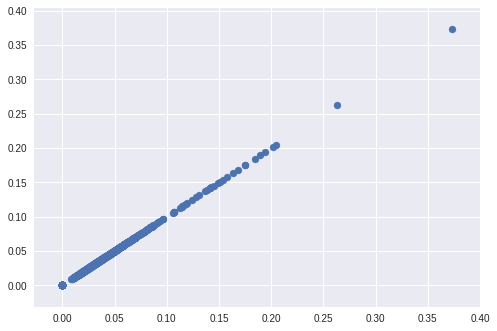

In [19]:
plt.scatter(DI,DI_ref)